# 1. fxデータの準備
## 1.1 oanda apiを使って取得する．

In [1]:
# oanda apiを準備
from oandapyV20 import API

accountID = '101-009-16291431-001'
access_token = '156268eda25105092a3645be8c1cfe16-706f05085edb96bdaa27bd7f6d47552d'

api = API(access_token=access_token ,environment="practice")

In [2]:
import json
import pandas as pd
import oandapyV20.endpoints.instruments as instruments
from oandapyV20.types import DateTime
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

PRICE_DICT = {'M': 'mid', 'A': 'ask', 'B': 'bid'}

def columns_for_price(price_kind):
    return ['Time', f'Open_{price_kind}', f'High_{price_kind}', f'Low_{price_kind}', f'Close_{price_kind}', 'Volume' ]

def instrument_candle_request(since, until, granularity, price_key, instrument):
    params = { "from": DateTime(since).value,
              "to": DateTime(until).value,
              "price": price_key,
              "granularity": granularity}
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    api.request(r)
    return r

"""
since: 開始時刻, datetime.datetime
until: 終了時刻, datetime.datetime
granularity: 時間間隔, string
price: 'A'(Ask), 'B'(Bid), 'M'(Mid)で参照する価格の種類を指定．, string

"""

def load_equity_df(since, until, granularity, price_key, instrument) :
    r = instrument_candle_request(since, until, granularity, price_key, instrument)
    price = PRICE_DICT.get(price_key) or 'mid'
    raws = [[raw['time'], *raw[price].values(), raw['volume']] for raw in r.response['candles']]
    df = pd.DataFrame(raws, columns=columns_for_price(price))
    return df

def one_day_fx_df(instrument):
    since = datetime.strptime( '2014-01-01' ,'%Y-%m-%d' )
    until = datetime.strptime( '2019-12-31' ,'%Y-%m-%d' )
    granularity = 'D'

    df_a = load_equity_df(since, until, granularity, 'A', instrument)
    df_b = load_equity_df(since, until, granularity, 'B', instrument)
    
    # 整形
    df = pd.merge(df_a, df_b)
    df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d')
    df = df.set_index('Time')
    
    # 保存
    df.to_csv(f'data/fx_data_{instrument}')
    
    print(instrument)
    return df

## データの取得
### 条件
- 6年分のデータ
    - 開始: 2014/01/01
    - 終了: 2019/12/31
- 間隔(granularity): 1日
- 内容: 買値(ask)と売値(bid)それぞれで始値，終値，高値，安値,出来高を取得

### 注意
- 土日は取引できないのでデータも存在しない．

In [3]:
# データ取得実行
instrument_list = ['USD_JPY', 'GBP_JPY', 'EUR_JPY']
for instrument in instrument_list:
    one_day_fx_df(instrument)

USD_JPY
GBP_JPY
EUR_JPY


## 1.2 test train split
6年分のデータをtrain(５年)，test(1年)に分けてcsvで保存．

In [22]:
instrument_list = ['USD_JPY', 'GBP_JPY', 'EUR_JPY'] # 再掲
df_dict = {}
for instrument in instrument_list:
    df = pd.read_csv(f'data/fx_data_{instrument}', index_col=0, header=0)
    df.index = pd.to_datetime(df.index)
    df_train, df_test = df.iloc[:-275], df.iloc[-275:]
    df_train.to_csv(f'data/fx_data_{instrument}_train')
    df_test.to_csv(f'data/fx_data_{instrument}_test')

# 2. 読み込みと可視化
TODO: データの数を揃える
csvの読み込みと整形

In [2]:
import pandas as pd

In [3]:
instrument_list = ['USD_JPY', 'GBP_JPY', 'EUR_JPY'] # 再掲
df_dict = {}
for instrument in instrument_list:
    df = pd.read_csv(f'data/fx_data_{instrument}', index_col=0, header=0)
    df.index = pd.to_datetime(df.index)
    df_dict[instrument] = df

In [9]:
for df in df_dict.values():
    print(len(df))


1573
1562
1558


In [27]:
import matplotlib.pyplot as plt
from mpl_finance import candlestick2_ohlc as plt_candle
# from matplotlib.finance import candlestick2_ohlc as plt_candle 失敗
import numpy as np

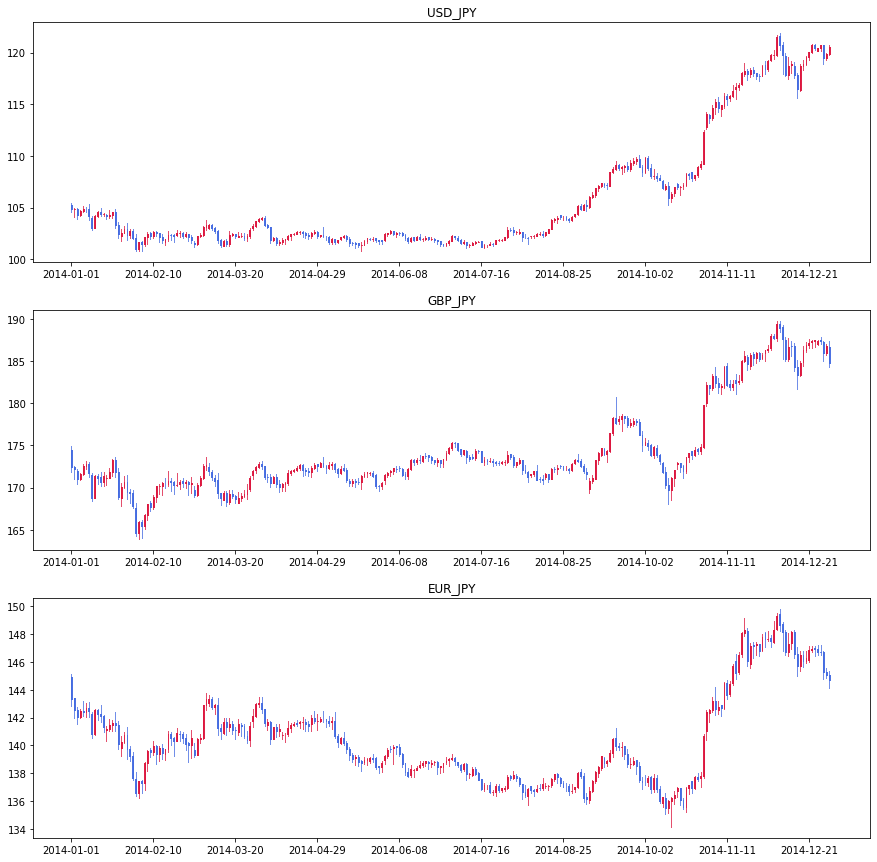

In [42]:
N = 260
fig = plt.figure(figsize=(15, 15))
for i in range(3):
    inst = instrument_list[i]
    df = df_dict[inst]
    ax = fig.add_subplot(3, 1, i+1)
    t_index = [t.strftime('%Y-%m-%d') for t in df_usd.index[:N]]
    plt_candle(ax,
                opens = df['Open_ask'][:N],
                highs = df['High_ask'][:N],
                lows = df['Low_ask'][:N],
                closes = df['Close_ask'][:N],
                width=0.3,
                colorup='#DC143C',
                colordown='#4169E1')
    ax.set_title(inst)
    _ = ax.set_xticks(np.arange(N)[::int(N/9)])
    _ = ax.set_xticklabels(t_index[::int(N/9)])